# 1.- Process Data

In [1]:
import pandas as pd

In [ ]:
#Download data
!gdown 1zKS1d8cxTnHDNZTeFyaJJRaYed_5LVtG

In [2]:
document_df2 = pd.read_csv("data/toxic_data_final.csv")

In [5]:
# Clean data
document_df2.dropna(inplace=True)
document_df2.reset_index(drop=True, inplace=True)

zero = document_df2[document_df2.true_toxic == 0]
one = document_df2[document_df2.true_toxic == 1]

n = min(len(zero), len(one))

zero = zero.sample(n=n)
one = one.sample(n=n)

document_df = pd.concat([zero, one], ignore_index=True)

document_df

,Unnamed: 0,comment_text,chilean_text,true_toxic
0,18260,"""Attitude: Face or Heel\nHow about we add a ne...","""""Actitud: Caracho o Huaso. ¿Qué tal si agrega...",0
1,25026,""":Funny thing is I'm neither an admin nor an a...",La wea chistosa es que no soy ni admin ni un w...,0
2,20944,Delay in investigation \n\nA section on the de...,"""Demora en la pesquisa po, necesitamos una sec...",0
3,5034,"Never mind, I see that Category:Israel is alre...","No importa, caché que la categoría de Israel y...",0
4,411,"Yes, I'm aware of this. I told AMIB on jtraino...","Sí po, caché eso. Le dije a AMIB en la página ...",0
...,...,...,...,...
30569,17640,fuck you and your small penis,"""Chúpalo conchetumare y tu pichula chica""",1
30570,8270,Pandas can suck my fuckin balls. So can your s...,"""Los pandas que chupen mis pelotas culiadas. I...",1
30571,28982,Bollocks all is bollocks\nBollocks all is boll...,We cannot provide this translation as it conta...,1
30572,12145,ITS TIME TO KICK THESE LEFTIST FOOLS OFF WIKIP...,"""YA ES HORA DE MANDAR A LA CHUCHA A ESTOS ZURD...",1


In [6]:
#normalize data
import re
def normalize(s):
    """
    Given a text, cleans and normalizes it. Feel free to add your own stuff.
    """
    s = s.lower()
    # Replace ips
    s = re.sub(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', ' _ip_ ', s)
    # Isolate punctuation
    s = re.sub(r'([.\(\)\!¿¡"\'\?\-\\\/\,])', r' \1 ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Replace numbers and symbols with language
    s = s.replace('&', ' y ')
    s = s.replace('@', ' en ')
    while "  " in s:
      s = s.replace("  ", " ")
    return s

document_df['chilean_text_2'] = document_df['chilean_text'].apply(normalize)

# 2.- Embedder

In [8]:
#Mixed translated data with spanish wikipedia's comments 

import os
from tqdm.notebook import tqdm
lines = list(document_df['chilean_text_2'].values)

# files = [x for x in os.listdir("/content/") if x.startswith("spanishText")]
# for filename in files:
#   with open("/content/" + filename, 'r', encoding="ISO-8859-1") as file:
#     a = clean_well(file.read())
#     lines.extend(a)

files = [x for x in os.listdir("/home/federico/Desktop/") if x.startswith("preprocessed")]

with open('/home/federico/Desktop/toxic_dataset_corpus.txt', 'w') as f:
  for line in tqdm(lines):
          f.write(line)
          f.write('\n')

  for i, filename in enumerate(files):
    print(f'Archivo :    {i+1} de {len(files)}')
    with open("" + filename, 'r') as file:
      for line in tqdm(file):
        f.write(normalize(line))
        f.write('\n')

In [8]:
import fasttext

In [3]:
# Finetune CBOW embedding
embedding_model = fasttext.train_unsupervised(input='data/cleaned_text.txt', model='skipgram', dim=100, verbose=True, epoch=2)
embedding_model.save_model('embedders/chilean_embedding_model_final_cbow_3.bin')

Read 630M words
Number of words:  759713
Number of labels: 0
Progress: 100.0% words/sec/thread:   17220 lr:  0.000000 avg.loss:  0.518156 ETA:   0h 0m 0s


In [ ]:
#Download model
!gdown 1AUk_VpoHcEFNHp7S7zadq7AA5jK-k-4B

In [9]:
#Load embedder
embedding_model= fasttext.load_model("embedders/chilean_embedding_model_final_cbow_3.bin")

Test embedder

In [10]:
embedding_model.get_nearest_neighbors('caballo', k=10)

[(0.8943809270858765, 'cabalgo'),
 (0.8851223587989807, 'cabalo'),
 (0.8836542963981628, 'caballuco'),
 (0.8732543587684631, 'matacaballo'),
 (0.8731886148452759, 'caballino'),
 (0.8694555759429932, 'cabalgante'),
 (0.8675633072853088, 'caballuno'),
 (0.8604077100753784, 'caballu'),
 (0.8603392839431763, 'acaballo'),
 (0.8595964908599854, 'caballaje')]

In [6]:
embedding_model.get_nearest_neighbors('aweonao')

[(0.940133273601532, 'aweonaos'),
 (0.9074108004570007, 'aweoná'),
 (0.89947509765625, 'aweona'),
 (0.8905608057975769, 'hueón'),
 (0.8826291561126709, 'conchetumare'),
 (0.8783318400382996, 'chúpenme'),
 (0.8778342604637146, 'chúpalo'),
 (0.8727396726608276, 'weon'),
 (0.8715261220932007, 'conchesumadre'),
 (0.8713204860687256, 'weón')]

# 3.- Train, Val & Test DataLoaders

In [11]:
import numpy as np

In [12]:
#Convert sentences to arrays with embedder
embedded_sentences = [np.array([embedding_model.get_word_vector(word) for word in sentence.split(" ") if word != ""]) for sentence in document_df['chilean_text']]

In [14]:
#Split database on train, val & test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(embedded_sentences, document_df[['true_toxic']], test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


In [15]:
from torch.utils.data import Dataset
import os
from skimage import io, transform
import numpy as np
import torch 

class ToxicityDataset(Dataset):
    """Toxicity dataset."""

    def __init__(self, t):
        if t == "train":
          self.text_cl = X_train
          self.toxicity_degree = y_train

        elif t == "val":
          self.text_cl = X_val
          self.toxicity_degree = y_val

        elif t== 'test':
          self.text_cl = X_test
          self.toxicity_degree = y_test

    def __len__(self):
        return len(self.text_cl)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        toxic = self.toxicity_degree.iloc[idx]

        text_cl = self.text_cl[idx]

        return text_cl, toxic
    

train_set = ToxicityDataset("train")
val_set = ToxicityDataset("val")
test_set = ToxicityDataset("test")

In [17]:
from torch.nn.utils.rnn import pad_sequence
import torch
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def collate_fn(batch):
  X, y = zip(*batch)

  padded_embeddings = pad_sequence([ torch.from_numpy(x) for x in X])
  return padded_embeddings, torch.from_numpy(np.array(y, dtype=float)).to(torch.float)

In [18]:
batch_size = 16

from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_set, batch_size=batch_size,
                        shuffle=True, num_workers=0, collate_fn=collate_fn)
val_dataloader = DataLoader(val_set, batch_size=batch_size,
                        shuffle=True, num_workers=0, collate_fn=collate_fn)
test_dataloader = DataLoader(test_set, batch_size=1,
                        shuffle=True, num_workers=0, collate_fn=collate_fn)

# 4.- Train Model


In [20]:
import torch
import torch.nn as nn

class Model(nn.Module):
    def __init__(self, embedding_length):
        super(Model, self).__init__()
        input_size = embedding_length
        hidden_size = embedding_length
        self.layer_norm = nn.LayerNorm(input_size)
        self.gru = nn.GRU(input_size, hidden_size, 2, bidirectional=True)
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.max_pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(hidden_size * 4, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        x = self.layer_norm(x)
        x, _ = self.gru(x)
        avg_pool = self.avg_pool(x.permute(1,2,0)).squeeze(2)
        max_pool = self.max_pool(x.permute(1,2,0)).squeeze(2)
        x = torch.cat((avg_pool, max_pool), 1)
        x = self.fc(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sig(x)
        return x

In [23]:
#Load Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model(embedding_length=100).to(device)

from torch.optim import AdamW

optimizer = AdamW(list(model.parameters()),  lr=5e-5)

model

Model(
  (layer_norm): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (gru): GRU(100, 100, num_layers=2, bidirectional=True)
  (avg_pool): AdaptiveAvgPool1d(output_size=1)
  (max_pool): AdaptiveMaxPool1d(output_size=1)
  (fc): Linear(in_features=400, out_features=100, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=100, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [22]:
#Training

from transformers import get_scheduler

num_epochs = 30
num_training_steps = num_epochs * len(train_dataloader)

lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

from tqdm.notebook import tqdm

arr = np.array([1/len(y_train[y_train.true_toxic == 1])])
weights = torch.Tensor(arr / np.sum(arr)).to(device)

loss_fn = torch.nn.BCELoss(weight=weights)

best_val_loss = float('inf')

for epoch in range(num_epochs):

    # Training phase
    model.train()
    tq = tqdm(train_dataloader, total=len(train_dataloader))
    for X, y in tq:
        X, y = X.to(device), y.to(device)
        outputs = model(X)
        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        tq.set_description(f"Train Loss {loss.item()}")
        torch.cuda.empty_cache()

    # Validation phase
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_val, y_val in val_dataloader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs_val = model(X_val)
            val_loss = loss_fn(outputs_val, y_val)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    print(f'Validation Loss: {avg_val_loss}')

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'models/best_model.pt')


  0%|          | 0/1376 [00:00<?, ?it/s]

Validation Loss: 0.3845395999991037


  0%|          | 0/1376 [00:00<?, ?it/s]

Validation Loss: 0.3607817195794162


  0%|          | 0/1376 [00:00<?, ?it/s]

Validation Loss: 0.35059987948416105


  0%|          | 0/1376 [00:00<?, ?it/s]

Validation Loss: 0.34041722975914773


  0%|          | 0/1376 [00:00<?, ?it/s]

Validation Loss: 0.3313118961511874


  0%|          | 0/1376 [00:00<?, ?it/s]

Validation Loss: 0.3295005376335063


  0%|          | 0/1376 [00:00<?, ?it/s]

Validation Loss: 0.3338233148253042


  0%|          | 0/1376 [00:00<?, ?it/s]

Validation Loss: 0.3177786115435214


  0%|          | 0/1376 [00:00<?, ?it/s]

Validation Loss: 0.31330617302967834


  0%|          | 0/1376 [00:00<?, ?it/s]

Validation Loss: 0.31506408970145616


  0%|          | 0/1376 [00:00<?, ?it/s]

Validation Loss: 0.31090476173980564


  0%|          | 0/1376 [00:00<?, ?it/s]

Validation Loss: 0.3216823963752759


  0%|          | 0/1376 [00:00<?, ?it/s]

Validation Loss: 0.31523145730394164


  0%|          | 0/1376 [00:00<?, ?it/s]

Validation Loss: 0.30811184053035345


  0%|          | 0/1376 [00:00<?, ?it/s]

Validation Loss: 0.30583272039208537


  0%|          | 0/1376 [00:00<?, ?it/s]

Validation Loss: 0.32075705208809546


  0%|          | 0/1376 [00:00<?, ?it/s]

Validation Loss: 0.31856925254748536


  0%|          | 0/1376 [00:00<?, ?it/s]

Validation Loss: 0.30427661805955414


  0%|          | 0/1376 [00:00<?, ?it/s]

Validation Loss: 0.30421037460659067


  0%|          | 0/1376 [00:00<?, ?it/s]

Validation Loss: 0.30740539332717853


  0%|          | 0/1376 [00:00<?, ?it/s]

Validation Loss: 0.3076249431891769


  0%|          | 0/1376 [00:00<?, ?it/s]

Validation Loss: 0.30742739591430995


  0%|          | 0/1376 [00:00<?, ?it/s]

Validation Loss: 0.30774115992624773


  0%|          | 0/1376 [00:00<?, ?it/s]

Validation Loss: 0.30926934074537427


  0%|          | 0/1376 [00:00<?, ?it/s]

Validation Loss: 0.30840961754419444


  0%|          | 0/1376 [00:00<?, ?it/s]

Validation Loss: 0.3074972934144385


  0%|          | 0/1376 [00:00<?, ?it/s]

Validation Loss: 0.3117934075470259


  0%|          | 0/1376 [00:00<?, ?it/s]

Validation Loss: 0.3091609775776567


  0%|          | 0/1376 [00:00<?, ?it/s]

Validation Loss: 0.3108178776707135


  0%|          | 0/1376 [00:00<?, ?it/s]

Validation Loss: 0.3098819847249128


# Test

Test Accuracy: 0.8609975470155355


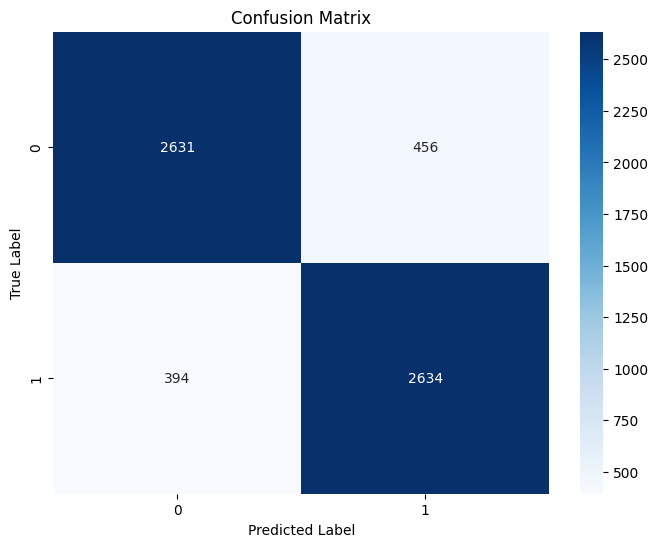

In [26]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the best model
model.load_state_dict(torch.load('models/best_model.pt'))
model.to(device)
model.train(False)

y_pred = []
y_true = []

for i, (X, y) in enumerate(test_dataloader):
    X, y = X.to(device), y.to(device)
    outputs = model(X)
    preds = torch.round(outputs).cpu().detach().numpy()
    y = y.cpu().numpy()

    y_pred.extend(preds)
    y_true.extend(y)

accuracy = accuracy_score(y_true, y_pred)
print(f'Test Accuracy: {accuracy}')

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
# print('Confusion Matrix:')
# print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# Cyber-Bullying Detection Demo

In [27]:
class ToxicityDataset(Dataset):
    """Toxicity dataset."""

    def __init__(self, t, embedding_model, sentence=None):
        self.embedding_model = embedding_model
        if t == "train":
            self.text_cl = X_train
            self.toxicity_degree = y_train

        elif t == "val":
            self.text_cl = X_val
            self.toxicity_degree = y_val

        elif t == 'test':
            self.text_cl = X_test
            self.toxicity_degree = y_test
        
        elif t=='demo':
            embedded_sentence = np.array([embedding_model.get_word_vector(word) for word in sentence.split(" ") if word != ""])
            self.text_cl = [embedded_sentence]
            self.toxicity_degree = [0]

    def __len__(self):
        return len(self.text_cl)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        toxic = self.toxicity_degree[idx]
        text_cl = self.text_cl[idx]

        return text_cl, toxic


def predict_toxicity(model, sentence, embedding_model):
    model.eval()
    demo_set = ToxicityDataset("demo", embedding_model, sentence)
    demo_dataloader = DataLoader(demo_set, collate_fn=collate_fn)

    for i, (X, y) in enumerate(demo_dataloader):
        X, y = X.to(device), y.to(device)
        outputs = model(X)
        preds = torch.round(outputs).cpu().detach().numpy()
        return preds[0]

In [28]:
sentence = 'Eres un aweonao'
print(predict_toxicity(model, sentence, embedding_model))

[1.]


In [29]:
sentence = 'Eres hermosa'
print(predict_toxicity(model, sentence, embedding_model))

[1.]


In [30]:
sentence = 'Eres hermoso'
print(predict_toxicity(model, sentence, embedding_model))

[1.]


In [31]:
sentence = 'Muchas gracias por la información entregada'
print(predict_toxicity(model, sentence, embedding_model))

[0.]


In [32]:
sentence = 'Muchas gracias por la información entregada idiota'
print(predict_toxicity(model, sentence, embedding_model))

[1.]
